### Summary
The sentiment140 dataset was used to clean tweets, train machine learning models.  
Tweets were cleaned to get rid of non-alphanumeric characters,url links and numerals
Stopwords were used from the nltk library with the exception of 'no' and 'not' as removing these from the text might impact the sentiment of the text  
Stemming and Lemmatization were used to reduce the tweet words to their lemma/root  
Term Frequency Inverse Document Frequency( TFIDF) was applied to convert tweets into vectors  
Logistic Regression, naive bayes and Support Vector Classification Machine learning models were applied and confusion matrixes and ROC were computed

### Sentiment140 Dataset Details

### Source: http://help.sentiment140.com/for-students

### Description
The training data was automatically created, as opposed to having humans manual annotate tweets. In the approach used, any tweet with positive emoticons, like :), were positive, and tweets with negative emoticons, like :(, were negative. We used the Twitter Search API to collect these tweets by using keyword search. This is described in the following paper(https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf)
The data is a CSV with emoticons removed.

### MetaData

Field Name |Description| 
------------|--------------|
sentiment | the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)  |
tweet_id| the id of the tweet |
tweet_date|the date of the tweet in UTC  |
query| the query used. If there is no query, then this value is NO_QUERY.  |
username| the user that tweeted  |
tweet|the text of the tweet  |

### Import libraries

In [51]:
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from datetime import datetime
%matplotlib inline
import re
import warnings
warnings.filterwarnings('ignore') 

#### Read from the input tweet file and assign column names

In [8]:
input_file_sentiment="E:\\python_projects\\Springboard\datasets\\twitter_sentiment140\\training_140_sentiment.csv"

In [9]:
#input_file_airline="E:\\python_projects\\Springboard\\datasets\\twitter_airline_sentiment\\Tweets.csv"

In [10]:
sentiment_colls=['sentiment','tweet_id','tweet_date','query','username','tweet']
tweet_df=pd.read_csv(input_file_sentiment,encoding='cp1252',names=sentiment_colls,usecols=['sentiment','tweet'])
#airline_df=pd.read_csv(input_file_airline,usecols=[1,10],names=['sentiment','tweet'],header=0)
#tweet_df=pd.concat([sentiment_df,airline_df])

In [11]:
tweet_df.shape

(1600000, 2)

In [12]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
sentiment    1600000 non-null int64
tweet        1600000 non-null object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


#### Check for any null values in the tweet field

In [13]:
np.sum(tweet_df.isnull())

sentiment    0
tweet        0
dtype: int64

#### Value counts on the output sentiment

In [14]:
tweet_df.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

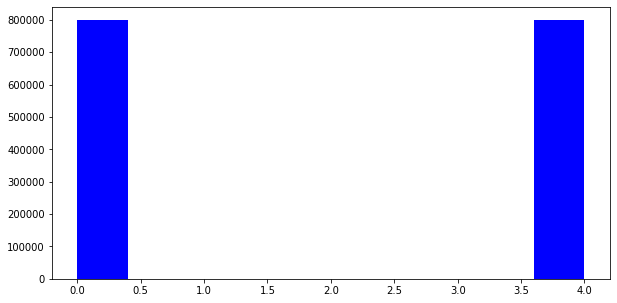

In [15]:
fig,ax=plt.subplots(figsize=(10,5))
ax.hist(tweet_df.sentiment,color='blue')
plt.show()

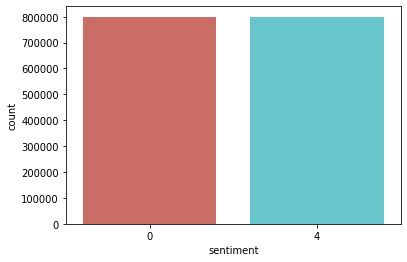

In [16]:
sns.countplot(x='sentiment',data=tweet_df,palette='hls');

In [17]:
df_cleaned=tweet_df[['tweet','sentiment']]


#### Adding stopwords from nltk and removing 'no' and 'not' from stopwords

In [18]:
stopwords_default=stopwords.words('english')

In [19]:
stopwords_updated=[word for word in stopwords_default if word not  in ['no','not'] ]


#### Cleanse Tweets to remove punctuations,@, urls

In [20]:
def cleanse_tweet(line):
    #remove any @ words
    tweet_no_refs=re.sub(r'@\S+|#\S+','',line)

    #remove any non alphanumeric character like or punctuations
    tweet_no_punctuation=re.sub(r'[^\w\s]','',tweet_no_refs)

    #remove url links
    tweet_no_urls=re.sub(r'https?\S+','',tweet_no_punctuation)  
       
    #remove numerals
    tweet_no_numerals=re.sub(r'[0-9]+','',tweet_no_urls)

    #remove stopwords
    tweet_stopwords=" ".join([word.lower() for word in tweet_no_numerals.split() if word not in stopwords_updated])
        
    return tweet_stopwords
    

In [23]:
df_cleaned['tweet_cleaned']=df_cleaned['tweet'].apply(lambda tweet:cleanse_tweet(tweet))
df_cleaned

,tweet,sentiment,tweet_cleaned
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,awww thats bummer you shoulda got david carr t...
1,is upset that he can't update his Facebook by ...,0,upset cant update facebook texting might cry r...
2,@Kenichan I dived many times for the ball. Man...,0,i dived many times ball managed save the rest ...
3,my whole body feels itchy and like its on fire,0,whole body feels itchy like fire
4,"@nationwideclass no, it's not behaving at all....",0,no not behaving im mad i cant see
...,...,...,...
1599995,Just woke up. Having no school is the best fee...,4,just woke having no school best feeling ever
1599996,TheWDB.com - Very cool to hear old Walt interv...,4,thewdbcom very cool hear old walt interviews â
1599997,Are you ready for your MoJo Makeover? Ask me f...,4,are ready mojo makeover ask details
1599998,Happy 38th Birthday to my boo of alll time!!! ...,4,happy th birthday boo alll time tupac amaru sh...


#### Tokenizing tweets

In [24]:
df_cleaned['tweet_tokenized']=df_cleaned['tweet_cleaned'].apply(lambda tweet:word_tokenize(tweet))

In [679]:
df_cleaned

,tweet,sentiment,tweet_cleaned,tweet_tokenized
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,awww thats bummer you shoulda got david carr t...,"[awww, thats, bummer, you, shoulda, got, david..."
1,is upset that he can't update his Facebook by ...,0,upset cant update facebook texting might cry r...,"[upset, cant, update, facebook, texting, might..."
2,@Kenichan I dived many times for the ball. Man...,0,i dived many times ball managed save the rest ...,"[i, dived, many, times, ball, managed, save, t..."
3,my whole body feels itchy and like its on fire,0,whole body feels itchy like fire,"[whole, body, feels, itchy, like, fire]"
4,"@nationwideclass no, it's not behaving at all....",0,no not behaving im mad i cant see,"[no, not, behaving, im, mad, i, cant, see]"
...,...,...,...,...
1599995,Just woke up. Having no school is the best fee...,4,just woke having no school best feeling ever,"[just, woke, having, no, school, best, feeling..."
1599996,TheWDB.com - Very cool to hear old Walt interv...,4,thewdbcom very cool hear old walt interviews â,"[thewdbcom, very, cool, hear, old, walt, inter..."
1599997,Are you ready for your MoJo Makeover? Ask me f...,4,are ready mojo makeover ask details,"[are, ready, mojo, makeover, ask, details]"
1599998,Happy 38th Birthday to my boo of alll time!!! ...,4,happy th birthday boo alll time tupac amaru sh...,"[happy, th, birthday, boo, alll, time, tupac, ..."


#### Stemming tweets

In [25]:
def tweet_stemming(tweet):
     return [SnowballStemmer('english').stem(word) for word in tweet]

In [26]:
df_cleaned['tweet_stem']=df_cleaned['tweet_tokenized'].apply(lambda tweet:tweet_stemming(tweet))

In [682]:
df_cleaned

,tweet,sentiment,tweet_cleaned,tweet_tokenized,tweet_stem
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,awww thats bummer you shoulda got david carr t...,"[awww, thats, bummer, you, shoulda, got, david...","[awww, that, bummer, you, shoulda, got, david,..."
1,is upset that he can't update his Facebook by ...,0,upset cant update facebook texting might cry r...,"[upset, cant, update, facebook, texting, might...","[upset, cant, updat, facebook, text, might, cr..."
2,@Kenichan I dived many times for the ball. Man...,0,i dived many times ball managed save the rest ...,"[i, dived, many, times, ball, managed, save, t...","[i, dive, mani, time, ball, manag, save, the, ..."
3,my whole body feels itchy and like its on fire,0,whole body feels itchy like fire,"[whole, body, feels, itchy, like, fire]","[whole, bodi, feel, itchi, like, fire]"
4,"@nationwideclass no, it's not behaving at all....",0,no not behaving im mad i cant see,"[no, not, behaving, im, mad, i, cant, see]","[no, not, behav, im, mad, i, cant, see]"
...,...,...,...,...,...
1599995,Just woke up. Having no school is the best fee...,4,just woke having no school best feeling ever,"[just, woke, having, no, school, best, feeling...","[just, woke, have, no, school, best, feel, ever]"
1599996,TheWDB.com - Very cool to hear old Walt interv...,4,thewdbcom very cool hear old walt interviews â,"[thewdbcom, very, cool, hear, old, walt, inter...","[thewdbcom, veri, cool, hear, old, walt, inter..."
1599997,Are you ready for your MoJo Makeover? Ask me f...,4,are ready mojo makeover ask details,"[are, ready, mojo, makeover, ask, details]","[are, readi, mojo, makeov, ask, detail]"
1599998,Happy 38th Birthday to my boo of alll time!!! ...,4,happy th birthday boo alll time tupac amaru sh...,"[happy, th, birthday, boo, alll, time, tupac, ...","[happi, th, birthday, boo, alll, time, tupac, ..."


#### Lemmatizing tweets

In [27]:
def tweet_lemmatize(tweet):
    return ' '.join(WordNetLemmatizer().lemmatize(word) for word in tweet)

In [28]:
df_cleaned['tweet_lemma']=df_cleaned['tweet_stem'].apply(lambda tweet:tweet_lemmatize(tweet))

In [29]:
df_cleaned

,tweet,sentiment,tweet_cleaned,tweet_tokenized,tweet_stem,tweet_lemma
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,awww thats bummer you shoulda got david carr t...,"[awww, thats, bummer, you, shoulda, got, david...","[awww, that, bummer, you, shoulda, got, david,...",awww that bummer you shoulda got david carr th...
1,is upset that he can't update his Facebook by ...,0,upset cant update facebook texting might cry r...,"[upset, cant, update, facebook, texting, might...","[upset, cant, updat, facebook, text, might, cr...",upset cant updat facebook text might cri resul...
2,@Kenichan I dived many times for the ball. Man...,0,i dived many times ball managed save the rest ...,"[i, dived, many, times, ball, managed, save, t...","[i, dive, mani, time, ball, manag, save, the, ...",i dive mani time ball manag save the rest go b...
3,my whole body feels itchy and like its on fire,0,whole body feels itchy like fire,"[whole, body, feels, itchy, like, fire]","[whole, bodi, feel, itchi, like, fire]",whole bodi feel itchi like fire
4,"@nationwideclass no, it's not behaving at all....",0,no not behaving im mad i cant see,"[no, not, behaving, im, mad, i, cant, see]","[no, not, behav, im, mad, i, cant, see]",no not behav im mad i cant see
...,...,...,...,...,...,...
1599995,Just woke up. Having no school is the best fee...,4,just woke having no school best feeling ever,"[just, woke, having, no, school, best, feeling...","[just, woke, have, no, school, best, feel, ever]",just woke have no school best feel ever
1599996,TheWDB.com - Very cool to hear old Walt interv...,4,thewdbcom very cool hear old walt interviews â,"[thewdbcom, very, cool, hear, old, walt, inter...","[thewdbcom, veri, cool, hear, old, walt, inter...",thewdbcom veri cool hear old walt interview â
1599997,Are you ready for your MoJo Makeover? Ask me f...,4,are ready mojo makeover ask details,"[are, ready, mojo, makeover, ask, details]","[are, readi, mojo, makeov, ask, detail]",are readi mojo makeov ask detail
1599998,Happy 38th Birthday to my boo of alll time!!! ...,4,happy th birthday boo alll time tupac amaru sh...,"[happy, th, birthday, boo, alll, time, tupac, ...","[happi, th, birthday, boo, alll, time, tupac, ...",happi th birthday boo alll time tupac amaru sh...


#### Tweet Vectorization

In [30]:
vectorizer=TfidfVectorizer(ngram_range=(1,2),max_features=500000)
df_X=vectorizer.fit_transform(df_cleaned['tweet_lemma'])


In [31]:
y=df_cleaned['sentiment'].apply(lambda x:1 if x==4 else x)
y


0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: sentiment, Length: 1600000, dtype: int64

#### Split into train and test

In [32]:
X_train,X_test,y_train,y_test=train_test_split(df_X,y,test_size=0.3,random_state=40)

### Train, Predict and model Matrixes

In [57]:
#generic function to train and test model, display confusion matrix, ROC curve
def model_evaluate(model):
    start_time=datetime.now()
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    print(f'accuracy score: {accuracy_score(y_test,y_pred)}')
    print(classification_report(y_test,y_pred))
    conf_matrix=confusion_matrix(y_test,y_pred)
    print(f'confusion_matrix\n')
    print(f'True Negetives : {conf_matrix[0][0]}')
    print(f'False Negetive : {conf_matrix[0][1]}')
    print(f'False Positive : {conf_matrix[1][0]}')
    print(f'True Positive : {conf_matrix[1][1]}')
    
   
    fpr,tpr,thresholds=roc_curve(y_test,y_pred)
    auc_roc=auc(fpr,tpr)
    fig,ax=plt.subplots(1,2,figsize=(10,5))
    fig.tight_layout(pad=6)
    ax[0].plot(fpr,tpr,color='green',label='ROC Curve(area under curve : %0.00f)'% auc_roc)
    
    ax[0].set(title='ROC Curve',xlabel='False Positive Rate',ylabel='True Positive Rate')
    ax[0].grid(True)
    ax[1]=sns.heatmap(conf_matrix,cmap='Blues')
    ax[1].set(title='Confusion Matrix',ylabel='Actual Values',xlabel='Predicted Values')
    #plt.show();
    end_time=datetime.now()
    print(f'total time taken(minutes) :{((end_time-start_time).total_seconds())/60}')
    

#### Logistic Regression Model

accuracy score: 0.8079458333333334
              precision    recall  f1-score   support

           0       0.82      0.79      0.80    239943
           1       0.80      0.82      0.81    240057

    accuracy                           0.81    480000
   macro avg       0.81      0.81      0.81    480000
weighted avg       0.81      0.81      0.81    480000

confusion_matrix

True Negetives : 190277
False Negetive : 49666
False Positive : 42520
True Positive : 197537
total time taken(minutes) :0.9307428000000001


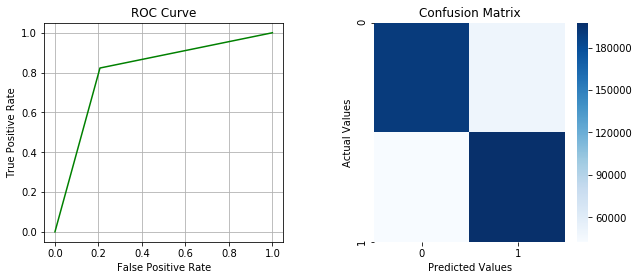

In [59]:
lrmodel=LogisticRegression()
model_evaluate(lrmodel)

#### Support Vector Classification

accuracy score: 0.7913479166666667
              precision    recall  f1-score   support

           0       0.80      0.78      0.79    239943
           1       0.78      0.80      0.79    240057

    accuracy                           0.79    480000
   macro avg       0.79      0.79      0.79    480000
weighted avg       0.79      0.79      0.79    480000

confusion_matrix

True Negetives : 187131
False Negetive : 52812
False Positive : 47341
True Positive : 192716
total time taken(minutes) :8.614949983333334


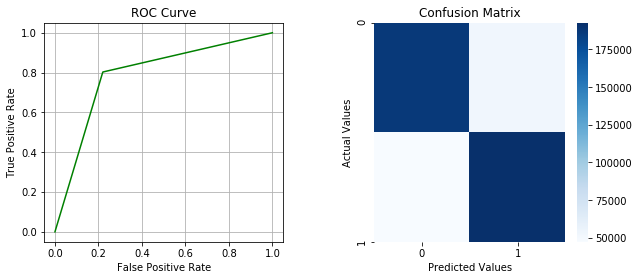

In [60]:
svcmodel=LinearSVC()
model_evaluate(svcmodel)

#### Naive Bayes classifier

accuracy score: 0.7886083333333334
              precision    recall  f1-score   support

           0       0.80      0.77      0.78    239943
           1       0.78      0.81      0.79    240057

    accuracy                           0.79    480000
   macro avg       0.79      0.79      0.79    480000
weighted avg       0.79      0.79      0.79    480000

confusion_matrix

True Negetives: 184104
False Negetive55839
False Positive45629
True Positive194428


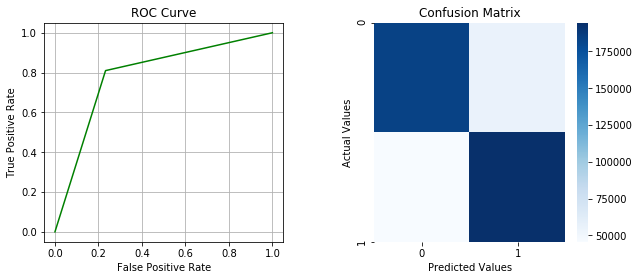

In [36]:
nbmodel=BernoulliNB()
model_evaluate(nbmodel)

### Using a Voting Classifier 

accuracy score: 0.8052229166666667
              precision    recall  f1-score   support

           0       0.81      0.79      0.80    239943
           1       0.80      0.82      0.81    240057

    accuracy                           0.81    480000
   macro avg       0.81      0.81      0.81    480000
weighted avg       0.81      0.81      0.81    480000

confusion_matrix

True Negetives: 189975
False Negetive49968
False Positive43525
True Positive196532


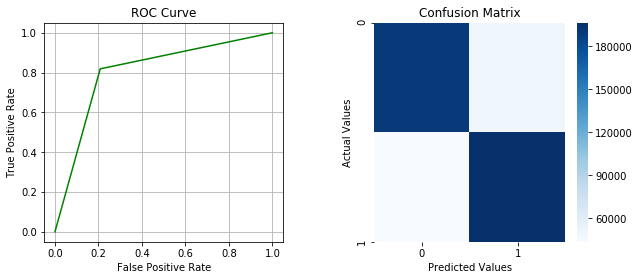

In [38]:
voting_clf=VotingClassifier(estimators=[('nb',nbmodel),('svc',svcmodel),('lr',lrmodel)],voting='hard')
model_evaluate(voting_clf)

### Using a decison tree classifier

accuracy score: 0.805275
              precision    recall  f1-score   support

           0       0.81      0.79      0.80    239943
           1       0.80      0.82      0.81    240057

    accuracy                           0.81    480000
   macro avg       0.81      0.81      0.81    480000
weighted avg       0.81      0.81      0.81    480000

confusion_matrix

True Negetives: 190013
False Negetive49930
False Positive43538
True Positive196519


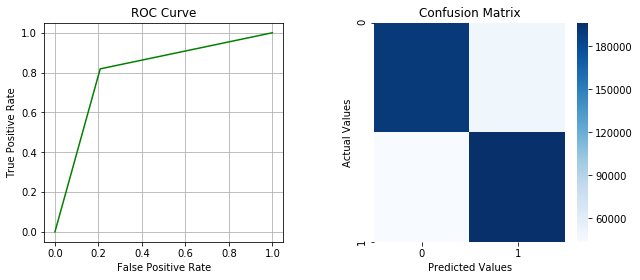

In [40]:
tree_clf=DecisionTreeClassifier(max_depth=100)
model_evaluate(voting_clf)

### Using a Bagging classifier (sampling features and training data)

accuracy score: 0.6683145833333334
              precision    recall  f1-score   support

           0       0.77      0.48      0.59    239943
           1       0.62      0.85      0.72    240057

    accuracy                           0.67    480000
   macro avg       0.70      0.67      0.66    480000
weighted avg       0.70      0.67      0.66    480000

confusion_matrix

True Negetives : 115683
False Negetive : 124260
False Positive : 34949
True Positive : 205108
total time taken(minutes) :2.8930333


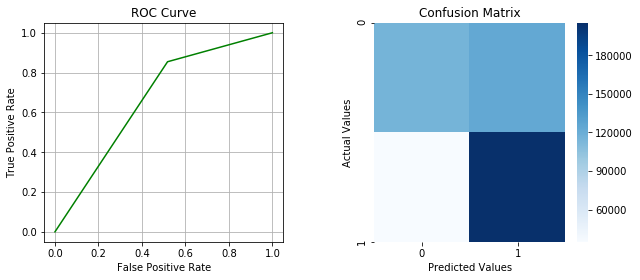

In [58]:
bagging_clf=BaggingClassifier(DecisionTreeClassifier(),n_estimators=500,max_samples=100,bootstrap=True,n_jobs=-1,bootstrap_features=True,max_features=0.3)
model_evaluate(bagging_clf)